# Structured Text

## The Problem

I've followed NCAA Wrestling for many years, and lately have taken an interest in talent identification and athlete development.

Consider, for example, the problem of recuiting collegiate wrestlers. Pontential scholarship athletes will commonly be screened from high school teams (in rare cases, international wrestlers may come from club teams); thus, there is consider interest in high school rankings. See, for example,

- [Intermat](https://intermatwrestle.com/rankings/high_school)
- [The Open Mat](https://news.theopenmat.com/category/high-school-wrestling/high-school-wrestling-rankings)
- [WIN](https://www.win-magazine.com/category/hs-rankings/)

It might be useful to compare these different ranking services to determine which are best at predicting collegiate success. To the end, I've decided to compare the 2015 high school class with the results from the 2018 NCAA tournament.

##  Manual Solution

- Copied table from [The Open Mat]('https://news.theopenmat.com/high-school-wrestling/high-school-wrestling-rankings/final-2015-clinch-gear-national-high-school-wrestling-individual-rankings/57136') into Excel, edited and saved as [CSV](./openmat2015.csv)
- Copied data from the 2018 NCAA Tournament from [PDF source](https://i.turner.ncaa.com/sites/default/files/external/gametool/brackets/wrestling_d1_2018.pdf) and from [FloArena](https://arena.flowrestling.org/event/8f1c1320-e1ac-31b5-c401-e7dda525e4b3) and compiled into [CSV](./ncaa2018.csv). These data also include final rankings from the Coaches Poll and [WrestleStat](https://www.wrestlestat.com/season/2018/rankings/starters) and results from various conference tournaments.


Can we merge these two tables to determine how top rank 2015 high school wrestlers performed in 2018?

In [ ]:
Read tables

In [45]:
import pandas

ncaa18_dat = pandas.read_csv("./ncaa2018.csv")
hs2015_dat = pandas.read_csv("./openmat2015.csv")

Remove the non-qualifiers from the NCAA data set.

In [46]:
ncaa18_dat = ncaa18_dat[ncaa18_dat.Finish != 'NQ']

Process wrestler names in the high school set to match the NCAA format.

In [47]:
names = hs2015_dat['Name'].apply(lambda x: x.split(' '))
names_dat = pandas.DataFrame(list(zip(*names)))
names_dat = names_dat.T
names_dat.rename(columns = {0:'First', 1:'Last'}, inplace = True)
hs2015_dat = pandas.concat([hs2015_dat, names_dat], axis=1)

In [ ]:
To simplify analysis, group ranks into quantiles:

In [65]:
import math
max_rank = max(hs2015_dat.Rank)
hs2015_dat['Quartile'] = hs2015_dat['Rank'].apply(lambda x: math.ceil(4*x/max_rank))

     Weight  Rank               Name Year            School State  \
0       106     1        Cade Olivas  Fr.    St. John Bosco    CA   
1       106     2  Roman Bravo-Young  Fr.         Sunnyside    AZ   
2       106     3     Gavin Teasdale  Fr.  Jefferson-Morgan    PA   
3       106     4        Drew Mattin  So.             Delta    OH   
4       106     5         Real Woods  Fr.  Montini Catholic    IL   
..      ...   ...                ...  ...               ...   ...   
275     285    16         Bo Spiller  Sr.           Solanco    PA   
276     285    17        Que Overton  Sr.             Jenks    OK   
277     285    18        Elliott Lee  Sr.            Archer    GA   
278     285    19     Norman Oglesby  Sr.    Benjamin Davis    IN   
279     285    20        Nick Rivera  So.    Brick Memorial    NJ   

                   College Previous    First         Last  Quartile  
0                      NaN        1     Cade       Olivas         1  
1                      NaN     


### How well does high school ranking predict participation in the NCAA tournament?


In [93]:
merged_dat = pandas.merge(hs2015_dat, ncaa18_dat, on=['First', 'Last'],how='inner')
pandas.crosstab(merged_dat.Quartile,merged_dat.Finish)

Finish,1,2,3,4,5,6,7,8,cons 12,cons 16,cons 24,cons 32,cons 33
Quartile,,,,,,,,,,,,,
1,4,3,1,2,2,2,1,0,5,4,5,2,0
2,0,1,0,1,1,1,0,2,2,1,5,1,1
3,0,0,0,0,0,0,0,1,2,1,3,2,0
4,0,0,0,0,1,0,0,0,0,0,2,3,0


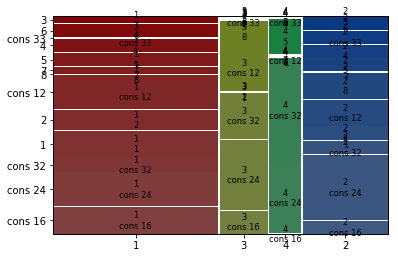

In [94]:
from statsmodels.graphics.mosaicplot import mosaic
plt = mosaic(merged_dat, ['Quartile', 'Finish'])

In [95]:
### What is the relationship between high school rank and NCAA place?

In [96]:
merged_dat = pandas.merge(hs2015_dat, ncaa18_dat, on=['First', 'Last'],how='outer',left_index=True, right_index=True)
merged_dat['Quartile']=merged_dat.Quartile.fillna(5)
merged_dat['Finish']=merged_dat.Finish.fillna('NQ')
pandas.crosstab(merged_dat.Quartile,merged_dat.Finish)

Finish,1,2,3,4,5,6,7,8,NQ,cons 12,cons 16,cons 24,cons 32,cons 33
Quartile,,,,,,,,,,,,,,
1.0,2,1,0,2,1,0,1,1,45,3,2,7,5,0
2.0,1,1,2,2,0,1,0,1,35,3,8,10,6,0
3.0,0,0,1,0,1,2,0,1,42,5,3,6,8,1
4.0,1,2,1,0,2,0,2,1,31,4,3,9,12,2
5.0,6,6,6,6,6,7,7,6,0,25,24,48,49,7


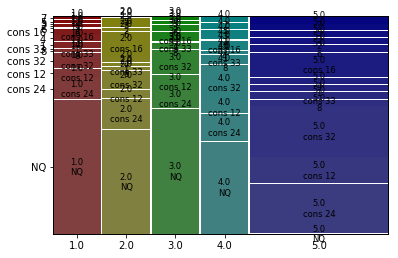

In [91]:
from statsmodels.graphics.mosaicplot import mosaic
plt = mosaic(merged_dat, ['Quartile', 'Finish'])

# Web Scraping solution

The data in `openmat2015.csv` were copied from a table in

https://news.theopenmat.com/high-school-wrestling/high-school-wrestling-rankings/final-2015-clinch-gear-national-high-school-wrestling-individual-rankings/57136

Can we 'scrape' this table directly?

In [97]:
path = 'https://news.theopenmat.com/high-school-wrestling/high-school-wrestling-rankings/final-2015-clinch-gear-national-high-school-wrestling-individual-rankings/57136'

In [68]:
from lxml import html
import requests
page = requests.get(path)
tree = html.fromstring(page.content)
print(tree)

print(page.content[1:100])


<Element html at 0x1091b38f0>
b'!DOCTYPE html><html lang="en-US"><head><meta charset="UTF-8">\n<script type="text/javascript">\n\tvar '


In [73]:
table = tree.xpath('//table')
print(table)

[<Element table at 0x1091b3f50>]


In [74]:
table = tree.xpath('//table/node()')
print(table)

['\n', <Element thead at 0x1091b3ef0>, '\n', <Element tbody at 0x11cbf08f0>, '\n']


In [88]:
table_head = table[1].xpath('//th')
print(table_head)
print(table[1].xpath('//th/text()'))
print(table[1].xpath('//th/node()'))

[<Element th at 0x11cbf0a70>, <Element th at 0x11cbf0c50>, <Element th at 0x11cbf0cb0>, <Element th at 0x11cbf0d10>, <Element th at 0x11cbf0d70>, <Element th at 0x11cbf0dd0>, <Element th at 0x11cbf0e30>]
['Rank', 'First Last', 'Year', 'School ', 'State', 'College', 'Previous']
['Rank', 'First Last', 'Year', 'School ', 'State', 'College', 'Previous']


In [77]:
table_head = table[1].xpath('//th/node()')
print(table_head)

['Rank', 'First Last', 'Year', 'School ', 'State', 'College', 'Previous']


In [79]:
table_body = table[3].xpath('//tbody')
print(table_body)

[<Element tbody at 0x11cbf08f0>]


In [111]:
table_body_n = table[3].xpath('//tbody/node()')
print(table_body_n[0:9])

['\n', <Element tr at 0x10c2cd830>, '\n', <Element tr at 0x10c2cda70>, '\n', <Element tr at 0x10c2cdad0>, '\n', <Element tr at 0x10c2cdb30>, '\n']


https://www.crummy.com/software/BeautifulSoup/

In [114]:
table_row = table_body[9]
print(table_row)
print(table_row.text)
print(table_row.values())
print(table_row.items())
print(table_row.keys())
print(table_row.xpath('//tr/node()')[0:9])
print(table_row.xpath('//td/node()')[0:9])
print(table_row.xpath('//tr/text()')[0:9])
print(table_row.xpath('//td/text()')[0:9])

<Element tr at 0x10c2cdb90>

	
['row-6 even']
[('class', 'row-6 even')]
['class']
['\n\t', <Element th at 0x11cbf0a70>, <Element th at 0x11cbf0c50>, <Element th at 0x11cbf0cb0>, <Element th at 0x11cbf0d10>, <Element th at 0x11cbf0d70>, <Element th at 0x11cbf0dd0>, <Element th at 0x11cbf0e30>, '\n']
['106', '1', 'Cade Olivas', 'Fr.', 'St. John Bosco', 'CA', '1', '2', 'Roman Bravo-Young']
['\n\t', '\n', '\n\t', '\n', '\n\t', '\n', '\n\t', '\n', '\n\t']
['106', '1', 'Cade Olivas', 'Fr.', 'St. John Bosco', 'CA', '1', '2', 'Roman Bravo-Young']


In [103]:
table_columns = table_row.xpath('//tr/node()')
print(table_columns[0:20])
print(type(table_columns[2]))
print(table_columns[5].text)
print(table_columns[5].values())

['\n\t', <Element th at 0x11cbf0a70>, <Element th at 0x11cbf0c50>, <Element th at 0x11cbf0cb0>, <Element th at 0x11cbf0d10>, <Element th at 0x11cbf0d70>, <Element th at 0x11cbf0dd0>, <Element th at 0x11cbf0e30>, '\n', '\n\t', <Element td at 0x11cbf0e90>, <Element td at 0x11cbf0a10>, <Element td at 0x11cbf0ef0>, <Element td at 0x11cbf07d0>, <Element td at 0x11cbf09b0>, <Element td at 0x11cbf0890>, <Element td at 0x11cbf0950>, '\n', '\n\t', <Element td at 0x11cbf0530>]
<class 'lxml.html.HtmlElement'>
['column-5']


In [ ]:
print(table_row.xpath('//tr/td/node()'))

In [43]:
table_row = table_body[3]
print(table_row)
print(table_body[13])
table_columns = table_row.xpath('//td/node()')
print(table_columns)

<Element tr at 0x10c2fc3b0>
<Element tr at 0x10c279b90>
['106', '1', 'Cade Olivas', 'Fr.', 'St. John Bosco', 'CA', '1', '2', 'Roman Bravo-Young', 'Fr.', 'Sunnyside', 'AZ', '2', '3', 'Gavin Teasdale', 'Fr.', 'Jefferson-Morgan', 'PA', '3', '4', 'Drew Mattin', 'So.', 'Delta', 'OH', '5', '5', 'Real Woods', 'Fr.', 'Montini Catholic', 'IL', '6', '6', 'Jacori Teemer', 'Fr.', 'Long Beach', 'NY', '7', '7', 'Kade Evans ', 'Jr.', 'Davis', 'UT', '10', '8', 'Jaxon Cole', 'So.', 'North Summit', 'UT', '11', '9', 'Josh Humphreys', 'Fr.', 'Huntington', 'WV', '13', '10', 'Gerard Angelo', 'Fr.', 'Hanover Park', 'NJ', 'NR', '11', 'Jake Silverstein', 'Fr.', 'Hauppauge', 'NY', '17', '12', 'Michael McGee\xa0', 'So.', 'Plainfield (East)', 'IL', 'NR', '13', 'Patrick Glory', 'Fr.', 'Delbarton', 'NJ', '20', '14', 'Thomas Cox', 'Jr.', 'Deer Park', 'NY', '18', '15', 'Brody Teske', 'Fr.', 'Fort Dodge', 'IA', 'NR', '16', 'Louis Hayes', 'Jr.', 'Carl Sandbury', 'IL', '15', '17', 'John Tropea', 'Jr.', 'St. Joseph Montv

In [ ]:
print(table_row.xpath('//tr/text()'))
print(table_columns[0:20])

In [48]:
import pandas
tbl = pandas.read_html(path)
print(tbl)

[     Rank         First Last Year            School State  \
0     106                NaN  NaN               NaN   NaN   
1       1        Cade Olivas  Fr.    St. John Bosco    CA   
2       2  Roman Bravo-Young  Fr.         Sunnyside    AZ   
3       3     Gavin Teasdale  Fr.  Jefferson-Morgan    PA   
4       4        Drew Mattin  So.             Delta    OH   
..    ...                ...  ...               ...   ...   
289    16         Bo Spiller  Sr.           Solanco    PA   
290    17        Que Overton  Sr.             Jenks    OK   
291    18        Elliott Lee  Sr.            Archer    GA   
292    19     Norman Oglesby  Sr.    Benjamin Davis    IN   
293    20        Nick Rivera  So.    Brick Memorial    NJ   

                   College Previous  
0                      NaN      NaN  
1                      NaN        1  
2                      NaN        2  
3                      NaN        3  
4                      NaN        5  
..                     ...      ...  
